# Automatisierte Lösung für OpenAIs LunarLander mit Reinforcement Learning anhand Policy Learnings

@Autor Michael Greif

## Verwandte Arbeiten

- Code inspiriert von https://github.com/cristianleoo/Reinforcement-Learning/tree/main/4.%20Polict%20Gradient%20Methods


## Bibliotheken

1. **`os`**: Bietet Funktionen zur Interaktion mit dem Betriebssystem, z.B. für Dateipfade und Verzeichnisse.
   
2. **`gc`**: Ermöglicht die Steuerung des Garbage Collectors, was nützlich sein kann, um Speicher manuell freizugeben.
   
3. **`time`**: Stellt Funktionen für Zeitmessungen bereit, z.B. um die Dauer von Operationen zu messen.
   
4. **`numpy` (np)**: Die fundamentale Bibliothek für numerische Berechnungen in Python, insbesondere für das Arbeiten mit Arrays und Matrizen.
   
5. **`gymnasium` (gym)**: Eine Bibliothek zum Entwickeln und Vergleichen von Reinforcement Learning Algorithmen, die standardisierte Umgebungen (wie LunarLander) bereitstellt.
   
6. **`matplotlib.pyplot` (plt)**: Eine Plotting-Bibliothek, die zum Erstellen von statischen, animierten und interaktiven Visualisierungen in Python verwendet wird.
   
7. **`torch`**: Die Hauptbibliothek von PyTorch, einem Open-Source-Framework für maschinelles Lernen, das für das Bauen und Trainieren neuronaler Netze verwendet wird.
   
8. **`torch.nn` (nn)**: Ein Modul in PyTorch, das die Bausteine für neuronale Netze (wie Schichten, Aktivierungsfunktionen) und Verlustfunktionen bereitstellt.
   
9.  **`torch.optim` (optim)**: Ein Modul in PyTorch, das verschiedene Optimierungsalgorithmen (wie Adam, SGD) implementiert, die zur Anpassung der Gewichte neuronaler Netze während des Trainings verwendet werden.

In [1]:
import os
import gc
import time
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

## Hyperparameter

* **`MODEL_PATH`**: Speicherort für das trainierte Modell.
* **`SAVE_MODEL`**: Schaltet das Speichern des Modells nach dem Training ein/aus.
* **`RENDER_MODE`**: Legt fest, wie die Umgebung angezeigt wird (z.B. `'rgb_array'` für interne Darstellung, `'human'` für ein Fenster).
* **`TRAINING_EPISODES`**: Anzahl der Trainingsläufe in der Umgebung.
* **`GAMMA` (Diskontfaktor)**: Gewichtet zukünftige Belohnungen; höherer Wert = stärkere Berücksichtigung zukünftiger Belohnungen.
* **`LEARNING_RATE`**: Bestimmt die Anpassungsgröße der Netzwerk-Gewichte pro Trainingsschritt.

In [2]:
# Metadata
MODEL_PATH = './Model/PL_Model.pt'  # Path to save the model
SAVE_MODEL = True                   # Save the model after training
RENDER_MODE = 'rgb_array'           # Render mode for gym environment

#Hyperparameters
TRAINING_EPISODES = 15000   # Number of training episodes
GAMMA = 0.99                # Discount factor
LEARNING_RATE = 0.0001      # Learning rate for the optimizer

## Policy Network Architektur

Das `PolicyNetwork` ist ein neuronales Netz, das die **Aktionswahrscheinlichkeiten** des Agenten generiert.

* **Aufbau:** Es handelt sich um ein **Feedforward-Netzwerk** mit drei voll verbundenen Schichten (`nn.Linear`).
    * Die erste Schicht (`self.fc1`) empfängt den **Zustand des Agenten** (`state_dim`) und transformiert ihn in eine 256-dimensionale Darstellung.
    * Die zweite Schicht (`self.fc2`) reduziert diese Dimension weiter auf 128.
    * Die dritte Schicht (`self.fc3`) bildet die 128-dimensionale Darstellung auf die **Dimension des Aktionsraums** (`action_dim`) ab.
* **Aktivierungsfunktionen:**
    * Nach den ersten beiden voll verbundenen Schichten wird die **ReLU-Aktivierungsfunktion** (`torch.relu`) angewendet, um Nichtlinearität einzuführen.
    * Die letzte Schicht verwendet die **Softmax-Aktivierungsfunktion** (`torch.softmax`). Dies stellt sicher, dass die Ausgaben des Netzwerks als **Wahrscheinlichkeitsverteilung über die möglichen Aktionen** interpretiert werden können, da die Summe der Ausgaben 1 ergibt.
* **Funktion (Forward Pass):** Im `forward`-Durchlauf wird der Eingabezustand sequenziell durch die Schichten geleitet. Das finale Softmax-Output gibt für jeden möglichen Zustand die Wahrscheinlichkeit an, mit der jede Aktion ausgeführt werden sollte.

In [3]:
# Define the policy network architecture
class PolicyNetwork(nn.Module):
    """Policy Network for the agent."""
    def __init__(self, state_dim, action_dim):
        """Initialize the policy network."""
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        """Forward pass through the network."""
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

## Training des Agenten

Dieser Code-Abschnitt steuert den gesamten Trainingsprozess des Policy Learning Agenten in der LunarLander-Umgebung.

Die Funktion `policy_learning()` initialisiert die Umgebung und den `PLA_Agenten`. In einer Schleife durchläuft sie eine vordefinierte Anzahl von Episoden. Innerhalb jeder Episode interagiert der Agent mit der Umgebung, indem er Aktionen gemäß seiner aktuellen Policy auswählt, Belohnungen sammelt und den nächsten Zustand erhält. Die gesammelten Belohnungen und Log-Wahrscheinlichkeiten werden nach jeder Episode an die `learn`-Methode des Agenten übergeben, um die Policy zu aktualisieren. Der Trainingsfortschritt, wie die mittlere Belohnung pro 100 Episoden, wird ausgegeben. Nach Abschluss aller Episoden wird das trainierte Policy-Netzwerk gespeichert und die gesamte Lernkurve (Scores über Episoden) grafisch dargestellt, um die Performance-Entwicklung des Agenten zu visualisieren.

In [4]:
class PolicyGradientAgent:
    """Policy Gradient Agent using REINFORCE algorithm."""
    def __init__(self, env, policy_network, optimizer, model_path=MODEL_PATH, gamma=GAMMA):
        """Initialize the agent."""
        self.env = env
        self.policy_network = policy_network
        self.optimizer = optimizer
        self.model_path = model_path
        self.gamma = gamma

        # Load the model if it exists
        if os.path.isfile(self.model_path):
            self.policy_network.load_state_dict(torch.load(self.model_path))
            print(13 * '=' + ' Loaded model from disk ' + 13 * '=')
                
    def train(self, num_episodes, save_model=SAVE_MODEL):
        """Train the agent using Policy Gradients."""
        start_time = time.time()
        gc.enable()
        total_rewards = []
        

        for episode in range(num_episodes):
            state, _ = self.env.reset()
            total_reward = 0
            log_probs = []
            rewards = []

            for _ in range(1000):
                if RENDER_MODE == 'human':
                    self.env.render()

                state = torch.FloatTensor(state).unsqueeze(0)
                action_probs = self.policy_network(state)
                action = torch.multinomial(action_probs, 1).item()
                
                log_prob = torch.log(action_probs.squeeze(0)[action])
                log_probs.append(log_prob)
                
                next_state, reward, done, _, _ = self.env.step(action)
                
                rewards.append(reward)
                state = next_state
                total_reward += reward
                
                if done:
                    break
            
            total_rewards.append(total_reward)
            self.update_policy(log_probs, rewards)

            # print(f"Episode {episode}, Total Reward: {total_reward}")

            if episode % 50 == 0 and episode > 0:
                print(f"Episode {episode}, Average Reward: {np.mean(total_rewards[-50:]):.8f}")
                if save_model and episode % 1000 == 0:
                    torch.save(self.policy_network.state_dict(), self.model_path)
                    print(13 * '=' + ' Saved model to disk ' + 13 * '=')
            
            # Delete variables to free up memory
            del log_probs, rewards, state, action_probs, action
            gc.collect()

        # Save the model after training
        if save_model:
            print(f"Episode {episode}, Average Reward: {np.mean(total_rewards):.8f}")
            torch.save(self.policy_network.state_dict(), self.model_path)
            print(13 * '=' + ' Saved model to disk ' + 13 * '=')
        
        self.env.close()
        
        # Print training time
        print(f"Training completed after {time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))}.")
        
        print('\nPlotting results...')
        plt.figure(figsize=(12, 6))
        plt.title('Test Results')
        plt.plot(total_rewards, label='Scores')
        plt.plot([np.mean(total_rewards[:x]) for x in range(1, num_episodes+1)], label='Mean Score')
        plt.plot([np.median(total_rewards[:x]) for x in range(1, num_episodes+1)], label='Median Score')
        plt.fill_between(range(num_episodes), np.array(total_rewards) - np.std(total_rewards), np.array(total_rewards) + np.std(total_rewards), alpha=0.2)
        plt.legend()
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.grid()
        plt.show()

    def update_policy(self, log_probs, rewards):
        """"Update the policy using the REINFORCE algorithm."""
        
        # Compute discounted rewards
        discounted_rewards = []
        for t in range(len(rewards)):
            Gt = sum(self.gamma ** i * rewards[t + i] for i in range(len(rewards) - t))
            discounted_rewards.append(Gt)
        
        # Normalize the rewards
        discounted_rewards = torch.FloatTensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

        # Compute the policy loss
        policy_loss = []
        for log_prob, Gt in zip(log_probs, discounted_rewards):
            policy_loss.append(-log_prob * Gt)
        
        # Update the policy network
        self.optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        self.optimizer.step()

Episode 50, Average Reward: -174.83378766
Episode 100, Average Reward: -168.28642121
Episode 150, Average Reward: -149.20230333
Episode 200, Average Reward: -146.99689017
Episode 250, Average Reward: -147.01547752
Episode 300, Average Reward: -142.15457488
Episode 350, Average Reward: -145.15599483
Episode 400, Average Reward: -117.76568924
Episode 450, Average Reward: -154.61899883
Episode 500, Average Reward: -120.51261650
Episode 550, Average Reward: -122.30778671
Episode 600, Average Reward: -115.49161592
Episode 650, Average Reward: -119.88691558
Episode 700, Average Reward: -97.14719867
Episode 750, Average Reward: -126.93394963
Episode 800, Average Reward: -114.76878676
Episode 850, Average Reward: -86.98528266
Episode 900, Average Reward: -111.28302984
Episode 950, Average Reward: -82.17726556
Episode 1000, Average Reward: -109.02307663
============= Saved model to disk =============
Episode 1050, Average Reward: -99.51620050
Episode 1100, Average Reward: -102.47560236
Episode 

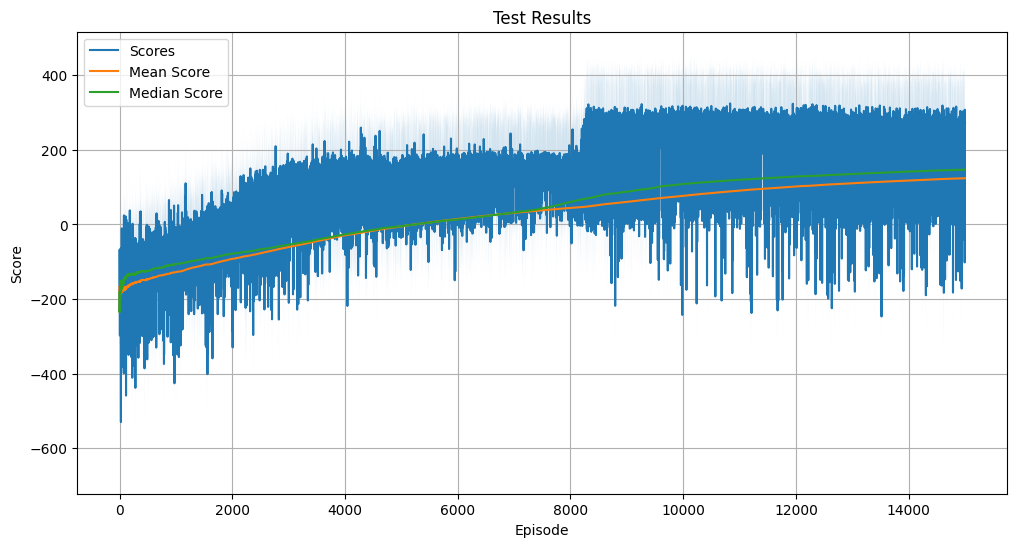

In [5]:
# Initialize environment, networks and optimizer
env = gym.make('LunarLander-v3', gravity=-10.0, render_mode=RENDER_MODE) 
policy_network = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy_network.parameters(), lr=LEARNING_RATE)
trainer = PolicyGradientAgent(env, policy_network, optimizer)
trainer.train(TRAINING_EPISODES, save_model=SAVE_MODEL)

**Kritische Bewertung des Trainingsverlaufs (Policy Gradient, REINFORCE):**

Das vorliegende Trainingsprotokoll des Policy Gradient Agenten auf der LunarLander-v3-Umgebung unterstreicht charakteristische Merkmale des REINFORCE-Algorithmus.

1.  **Initialisierung und frühe Lernphase:** Die initiale Leistungsmetrik, repräsentiert durch durchschnittliche Belohnungen im Bereich von ca. -170 in den ersten 100 Episoden, demonstriert den erwarteten geringen Performance-Start. Dies ist inhärent für On-Policy-Methoden ohne Replay-Memory, da die Policy-Updates unmittelbar auf individuellen, oft suboptimalen, Trajektorien basieren und eine breite Exploration zu Beginn des Lernprozesses induzieren.

2.  **Lernkurve und Konvergenzrate:** Der Agent weist über die gesamte Trainingsdauer von 15.000 Episoden eine kontinuierliche, wenngleich moderate, Verbesserung der durchschnittlichen Belohnungen auf. Ein signifikanter Übergang zu positiven Belohnungswerten wird erst nach ca. 2.450 Episoden beobachtet. Die Konvergenz zu einer stabilen, performanten Policy, erkennbar an durchschnittlichen Belohnungen über 200, setzt erst ab Episode 8.000 ein und festigt sich in den nachfolgenden Trainingsphasen. Dies illustriert die im Vergleich zu Off-Policy-Methoden wie Double DQN geringere Sample-Effizienz von REINFORCE, welche auf die einmalige Nutzung von Erfahrungsdaten für Gradientenaktualisierungen zurückzuführen ist.

3.  **Varianz des Gradienten:** Das Protokoll zeigt eine erhöhte Fluktuation der durchschnittlichen Belohnungen innerhalb der 50-Episoden-Intervalle, insbesondere in den frühen und mittleren Trainingsphasen. Diese Volatilität ist ein bekanntes Charakteristikum von Policy Gradient Methoden, die mit hochvarianteren Gradientenschätzern operieren, da der Gradient der Policy durch Stichproben von vollständigen Episodentrajektorien approximiert wird.

4.  **Ressourcenintensität:** Die Gesamttrainingsdauer von über 4 Stunden (04:20:04) für 15.000 Episoden unterstreicht den erhöhten Rechenaufwand und die Zeitintensität, die zur Erzielung eines konvergierten Verhaltens mit REINFORCE in dieser Umgebung erforderlich sind. Dies steht im Kontrast zu den typischerweise schnelleren Konvergenzzeiten von Off-Policy-Algorithmen, die durch die effiziente Wiederverwendung von Erfahrungen (Experience Replay) profitieren.

**Effektivität des Trainings:**

Trotz der aufgezeigten Herausforderungen hinsichtlich der Lernkurveneffizienz und Gradientenvarianz ist das Training als **effektiv** zu bewerten, da der Policy Gradient Agent erfolgreich eine Politik erlernt hat, die das LunarLander-v3-Problem löst und in den späteren Phasen konsistent hohe Belohnungen erzielt. Die erreichte Leistungsdichte in den finalen Trainingsepisoden, mit durchschnittlichen Belohnungen im Bereich von über 200, bestätigt die prinzipielle Anwendbarkeit und Leistungsfähigkeit des REINFORCE-Algorithmus für diese diskrete Kontrollaufgabe. Die Analyse verdeutlicht jedoch auch, dass für Umgebungen dieser Komplexität On-Policy-Methoden wie REINFORCE eine erhebliche Anzahl von Interaktionen erfordern können, um eine optimale oder vergleichbare Leistung zu den fortschrittlicheren Off-Policy-Algorithmen zu erzielen.

## Testen des Agenten

Nachdem das Policy Learning Modell erfolgreich trainiert wurde, ist es entscheidend, seine tatsächliche Leistung und Generalisierungsfähigkeit in der Umgebung zu evaluieren. Der folgende Testcode dient genau diesem Zweck: Er lädt das zuvor trainierte Agentenmodell und lässt es eine Reihe von Episoden in der LunarLander-Umgebung absolvieren, um Metriken wie die durchschnittliche Belohnung, die Erfolgsrate und die Schritte pro Episode zu erfassen. Dabei operiert der Agent ausschließlich basierend auf seinen erlernten Strategien, ohne weitere Exploration. Dies ermöglicht eine objektive Einschätzung der Effektivität des Trainings und der Fähigkeit des Agenten, das Gelernte auf die Umgebung anzuwenden.

In [ ]:
def test_agent(num_episodes=100, render_mode='human'):
    """Test the trained agent."""
    env = gym.make('LunarLander-v3', gravity=-10.0, render_mode=render_mode)
    agent = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
    agent.load_state_dict(torch.load(MODEL_PATH))
    agent.eval()
    all_rewards = []
    all_steps = []

    print("Testing the agent...")
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward, steps = 0, 0

        for _ in range(1000):
            state = torch.FloatTensor(state).unsqueeze(0)
            action_probs = agent(state)
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward
            steps += 1
            
            if terminated or truncated:
                break

        all_rewards.append(total_reward)
        all_steps.append(steps)

    env.close()
    
    print('\nTest Results:')
    print(f"\n{'Metric':<30} {'Value':<10}")
    print('-' * 40)
    print(f"{'Average Reward':<30} {np.mean(all_rewards):.4f}")
    print(f"{'Median Reward':<30} {np.median(all_rewards):.4f}")
    print(f"{'Standard Deviation':<30} {np.std(all_rewards):.4f}")
    print(f"{'Minimum Reward':<30} {np.min(all_rewards):.4f}")
    print(f"{'Maximum Reward':<30} {np.max(all_rewards):.4f}")
    print(f"{'Success Rate (>= 200)':<30} {np.mean(np.array(all_rewards) >= 200)*100:.2f} %")
    print('-' * 40)
    print(f"{'Total Episodes':<30} {num_episodes}")
    print(f"{'Total Steps':<30} {sum(all_steps)}")
    print(f"{'Average Steps per Episode':<30} {np.mean(all_steps):.2f}")
    print(f"{'Max Steps':<30} {np.max(all_steps)}")
    print(f"{'Min Steps':<30} {np.min(all_steps)}")
    print('-' * 40)
    print('Test completed.')
    
    print('\nPlotting results...')
    plt.figure(figsize=(12, 6))
    plt.title('Test Results')
    plt.plot(all_rewards, label='Scores')
    plt.plot([np.mean(all_rewards[:x]) for x in range(1, num_episodes+1)], label='Mean Score')
    plt.plot([np.median(all_rewards[:x]) for x in range(1, num_episodes+1)], label='Median Score')
    plt.fill_between(range(num_episodes), np.array(all_rewards) - np.std(all_rewards), np.array(all_rewards) + np.std(all_rewards), alpha=0.2)
    plt.legend()
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.grid()
    plt.show()

Testing the agent...

Test Results:

Metric                         Value     
----------------------------------------
Average Reward                 211.9822
Median Reward                  252.6126
Standard Deviation             100.0798
Minimum Reward                 -98.6771
Maximum Reward                 308.2362
Success Rate (>= 200)          79.00 %
----------------------------------------
Total Episodes                 100
Total Steps                    25460
Average Steps per Episode      254.60
Max Steps                      617
Min Steps                      109
----------------------------------------
Test completed.

Plotting results...


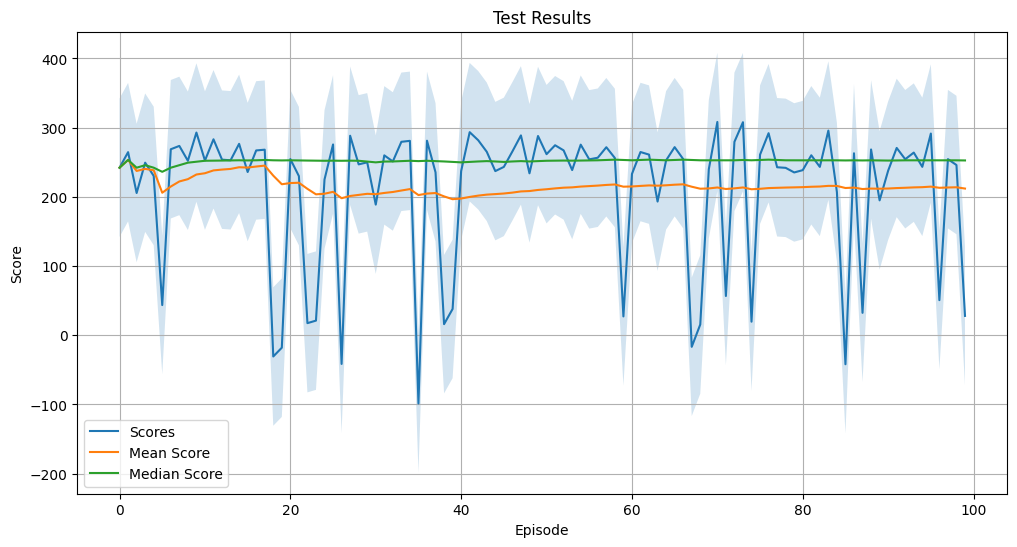

In [7]:
test_agent(num_episodes=100, render_mode='rgb_array')

Die vorliegenden Testergebnisse des Reinforcement Learning Agenten über 100 Episoden bieten eine differenzierte Perspektive auf dessen erlernte Fähigkeiten.

* **Durchschnittliche Belohnung (Average Reward): 211.9822**
    * Dieser Wert liegt über der typischen Erfolgsschwelle von 200 Punkten im LunarLander, was auf eine grundsätzlich erfolgreiche Landestrategie hindeutet.
    * Im Vergleich zur Median-Belohnung (252.6126) ist der Durchschnittswert jedoch niedriger, was darauf schließen lässt, dass eine signifikante Anzahl von Episoden mit deutlich geringeren Belohnungen den Mittelwert nach unten zieht. Dies deutet auf eine **Inkonsistenz in der Leistung** hin.

* **Median Belohnung (Median Reward): 252.6126**
    * Der Median ist ein robusteres Maß für die zentrale Tendenz und deutet darauf hin, dass in mehr als der Hälfte der Fälle der Agent sehr gute bis ausgezeichnete Leistungen erbracht hat. Dies bestätigt, dass der Agent das grundsätzliche Problem des Landens gut verstanden hat.

* **Standardabweichung (Standard Deviation): 100.0798**
    * Eine Standardabweichung von über 100 ist sehr hoch im Verhältnis zum Durchschnittswert. Dies ist der **signifikanteste Indikpunkt für die Variabilität und Instabilität der Leistung**. Die Spikes und Dips in der "Scores"-Linie im Graphen bestätigen diese hohe Volatilität. Dies impliziert, dass der Agent nicht immer eine zuverlässige oder konsistente Politik verfolgt. Es gibt Episoden, in denen er sehr gut abschneidet, und andere, in denen er deutlich schlechter performt oder sogar abstürzt.

* **Minimale Belohnung (Minimum Reward): -98.6771**
    * Das Auftreten von negativen Belohnungen zeigt, dass der Agent in einigen Episoden Fehlschläge oder suboptimale Landungen erzeugt hat (z.B. Abstürze oder hohe Treibstoffverbrauchswerte). Dies verstärkt die Annahme der Inkonsistenz.

* **Maximale Belohnung (Maximum Reward): 308.2362**
    * Der Maximalwert bestätigt, dass der Agent in der Lage ist, nahe am optimalen Ergebnis (typischerweise um 300 Punkte für eine perfekte Landung) zu operieren. Dies zeigt das Potenzial des gelernten Modells.

* **Erfolgsrate (Success Rate (>= 200)): 79.00 %**
    * Eine Erfolgsrate von 79% ist gut, aber nicht exzellent. Sie korreliert gut mit der Beobachtung, dass der Median über 200 liegt, der Durchschnitt aber darunter. Es bedeutet, dass in fast einem Fünftel der Fälle die Zielschwelle nicht erreicht wurde.

* **Schritte pro Episode (Average Steps per Episode: 254.60; Max Steps: 617; Min Steps: 109)**
    * Die durchschnittliche Schrittzahl ist moderat. Die hohe maximale Schrittzahl könnte auf ineffiziente Manöver in einigen Episoden hindeuten, während die niedrige minimale Schrittzahl auf schnelle, effiziente Landungen verweist.

## Fazit 

Der trainierte Reinforcement Learning Agent hat ein **grundsätzliches Verständnis für die Landeaufgabe** entwickelt und erreicht in einem Großteil der Episoden eine erfolgreiche Landung (79% Erfolgsrate über 200 Punkte). Die Median-Belohnung von über 250 Punkten zeigt das Potenzial für hohe Performance.

Allerdings leidet der Agent unter einer **signifikanten Leistungsinkonsistenz**, manifestiert durch die hohe Standardabweichung und das Auftreten von Episoden mit deutlich negativen Belohnungen. Dies deutet darauf hin, dass die erlernte Politik zwar oft effektiv ist, aber **nicht robust genug** gegenüber kleinen Variationen im Startzustand oder in den Umweltdynamiken. Für den Einsatz in kritischen Systemen, wie einer echten Mondlandung :), wäre diese Variabilität ein limitierender Faktor.

Weitere Forschung könnte sich auf Techniken zur **Reduzierung der Policy-Varianz** konzentrieren, beispielsweise durch stabilere Trainingsalgorithmen, Exploration-Strategien oder den Einsatz von Ensemble-Methoden, um die Robustheit und Zuverlässigkeit des Agenten auf ein konstant hohes Niveau zu heben.